In [133]:
import queue
import time
import math
from itertools import chain, combinations, product

import numpy as np
from numba import njit
from tqdm.auto import tqdm

from shap import Explanation, links
from shap.explainers._explainer import Explainer
from shap.models import Model
from shap.utils import MaskedModel, OpChain, make_masks, safe_isinstance


class PartitionExplainer3(Explainer):
    def __init__(
        self,
        model,
        masker,
        *,
        output_names=None,
        link=links.identity,
        linearize_link=True,
        feature_names=None,
        partition_tree=None,
        **call_args,
    ):
        super().__init__(
            model,
            masker,
            link=link,
            linearize_link=linearize_link,
            algorithm="partition",
            output_names=output_names,
            feature_names=feature_names,
        )

        self.input_shape = (
            masker.shape[1:]
            if hasattr(masker, "shape") and not callable(masker.shape)
            else None
        )
        if not safe_isinstance(self.model, "shap.models.Model"):
            self.model = Model(self.model)
        self.expected_value = None
        self._curr_base_value = None

        if self.input_shape is not None and len(self.input_shape) > 1:
            self._reshaped_model = lambda x: self.model(
                x.reshape(x.shape[0], *self.input_shape)
            )
        else:
            self._reshaped_model = self.model

        self.partition_tree = partition_tree
        if partition_tree is not None:
            self._clustering = None
        else:
            if not hasattr(masker, "clustering"):
                raise ValueError(
                    "The passed masker does not have masker.clustering, so the partition_tree must be passed!"
                )
            self._clustering = masker.clustering
            if not callable(masker.clustering):
                self._mask_matrix = make_masks(self._clustering)

        if len(call_args) > 0:
            class PartitionExplainer(self.__class__):
                def __call__(
                    self,
                    *args,
                    max_evals=500,
                    fixed_context=None,
                    main_effects=False,
                    error_bounds=False,
                    batch_size="auto",
                    outputs=None,
                    silent=False,
                ):
                    return super().__call__(
                        *args,
                        max_evals=max_evals,
                        fixed_context=fixed_context,
                        main_effects=main_effects,
                        error_bounds=error_bounds,
                        batch_size=batch_size,
                        outputs=outputs,
                        silent=silent,
                    )

            PartitionExplainer.__call__.__doc__ = self.__class__.__call__.__doc__
            self.__class__ = PartitionExplainer
            for k, v in call_args.items():
                self.__call__.__kwdefaults__[k] = v

    def __call__(
        self,
        *args,
        max_evals=500,
        fixed_context=None,
        main_effects=False,
        error_bounds=False,
        batch_size="auto",
        outputs=None,
        silent=False,
    ):
        return super().__call__(
            *args,
            max_evals=max_evals,
            fixed_context=fixed_context,
            main_effects=main_effects,
            error_bounds=error_bounds,
            batch_size=batch_size,
            outputs=outputs,
            silent=silent,
        )

    def explain_row(
        self,
        *row_args,
        max_evals,
        main_effects,
        error_bounds,
        batch_size,
        outputs,
        silent,
        fixed_context="auto",
    ):
        if fixed_context == "auto":
            fixed_context = None
        elif fixed_context not in [0, 1, None]:
            raise ValueError(
                "Unknown fixed_context value passed (must be 0, 1 or None): %s"
                % fixed_context
            )

        fm = MaskedModel(
            self.model, self.masker, self.link, self.linearize_link, *row_args
        )
        M = len(fm)
        m00 = np.zeros(M, dtype=bool)
        if self._curr_base_value is None or not getattr(
            self.masker, "fixed_background", False
        ):
            self._curr_base_value = fm(m00.reshape(1, -1), zero_index=0)[0]
        f11 = fm(~m00.reshape(1, -1))[0]

        if self.partition_tree is not None:
            return self.explain_with_partition_tree(fm, self._curr_base_value,  outputs)
        else:
            return self.explain_with_clustering(fm, self._curr_base_value, f11, max_evals, outputs, fixed_context, batch_size, silent)

    def explain_with_clustering(
        self, fm, f00, f11, max_evals, outputs, fixed_context, batch_size, silent
    ):
        if callable(self.masker.clustering):
            self._clustering = self.masker.clustering(*row_args)
            self._mask_matrix = make_masks(self._clustering)
        M = len(fm)
        m00 = np.zeros(M, dtype=bool)
        if (
            hasattr(self._curr_base_value, "shape")
            and len(self._curr_base_value.shape) > 0
        ):
            if outputs is None:
                outputs = np.arange(len(self._curr_base_value))
            elif isinstance(outputs, OpChain):
                outputs = outputs.apply(Explanation(f11)).values

            out_shape = (2 * self._clustering.shape[0] + 1, len(outputs))
        else:
            out_shape = (2 * self._clustering.shape[0] + 1,)

        if max_evals == "auto":
            max_evals = 500

        self.values = np.zeros(out_shape)
        self.dvalues = np.zeros(out_shape)

        self.winter(
            fm,
            self._curr_base_value,
            f11,
            max_evals - 2,
            outputs,
            fixed_context,
            batch_size,
            silent,
        )
        self.values[:] = self.dvalues
        lower_credit(len(self.dvalues) - 1, 0, M, self.values, self._clustering)
        return {
            "values": self.values[:M].copy(),
            "expected_values": self._curr_base_value
            if outputs is None
            else self._curr_base_value[outputs],
            "mask_shapes": [s + out_shape[1:] for s in fm.mask_shapes],
            "main_effects": None,
            "hierarchical_values": self.dvalues.copy(),
            "clustering": self._clustering,
            "output_indices": outputs,
            "output_names": getattr(self.model, "output_names", None),
        }

    def explain_with_partition_tree(self, fm, f00, outputs):
        # Step 1: Generate all unique masks
        self.root = Node("Root")
        build_tree(self.partition_tree, self.root)
        self.combinations_list = generate_paths_and_combinations(self.root)
        print(self.combinations_list)
        self.masks, self.keys = create_masks1(self.root, self.masker.feature_names)
        self.masks_dict = dict(zip(self.keys, self.masks))
        self.mask_permutations = create_combined_masks(self.combinations_list, self.masks_dict)
        print(self.mask_permutations, "\n")
        self.masks_list = [mask for _, mask, _ in self.mask_permutations]
        self.unique_masks_set = set(map(tuple, self.masks_list))
        self.unique_masks = [np.array(mask) for mask in self.unique_masks_set]

        # Step 2: Compute model results for all unique masks
        mask_results = {}
        for mask in self.unique_masks:
            result = fm(mask.reshape(1, -1))
            mask_results[tuple(mask)] = result

        # Step 3: Compute marginals for permutations
        shap_values = np.zeros(len(fm))
        last_key_to_off_indexes, last_key_to_on_indexes, weights = map_combinations_to_unique_masks(
            self.mask_permutations, self.unique_masks
        )

        feature_name_to_index = {name: idx for idx, name in enumerate(self.masker.feature_names)}

        # Step 4: Implement Owen values weighting
        for last_key in last_key_to_off_indexes:
            off_indexes = last_key_to_off_indexes[last_key]
            on_indexes = last_key_to_on_indexes[last_key]
            weight_list = weights[last_key]
            
            for off_index, on_index, weight in zip(off_indexes, on_indexes, weight_list):
                off_result = mask_results[tuple(self.unique_masks[off_index])]
                on_result = mask_results[tuple(self.unique_masks[on_index])]
                print(off_result)
                print(on_result)
                print(weight)

                marginal_contribution = (on_result - off_result) * weight
                print(marginal_contribution)
                shap_values[feature_name_to_index[last_key]] += marginal_contribution #.item()


        # Step 5: Return results
        return {
            "values": shap_values.copy(),
            "expected_values": f00,
            "mask_shapes": [s + () for s in fm.mask_shapes],
            "main_effects": None,
            "hierarchical_values": shap_values,
            "clustering": None,
            "output_indices": outputs,
            "output_names": getattr(self.model, "output_names", None),
        }

    def __str__(self):
        return "shap.explainers.PartitionExplainer()"

    def winter(
        self, fm, f00, f11, max_evals, output_indexes, fixed_context, batch_size, silent
    ):
        M = len(fm)
        m00 = np.zeros(
            M, dtype=bool
        )
        base_value = f00
        ind = len(self.dvalues) - 1

        if output_indexes is not None:
            f00 = f00[output_indexes]
            f11 = f11[output_indexes]

        q = queue.PriorityQueue()
        q.put(
            (0, 0, (m00, f00, f11, ind, 1.0))
        )
        eval_count = 0
        total_evals = min(
            max_evals, (M - 1) * M
        )
        pbar = None
        start_time = time.time()
        while not q.empty():
            if eval_count >= max_evals:
                while not q.empty():
                    m00, f00, f11, ind, weight = q.get()[2]
                    self.dvalues[ind] += (f11 - f00) * weight
                break

            batch_args = []
            batch_masks = []

            while (
                not q.empty()
                and len(batch_masks) < batch_size
                and eval_count + len(batch_masks) < max_evals
            ):
                m00, f00, f11, ind, weight = q.get()[2]

                lind = int(self._clustering[ind - M, 0]) if ind >= M else -1
                rind = int(self._clustering[ind - M, 1]) if ind >= M else -1

                if ind < M:
                    distance = -1
                else:
                    if self._clustering.shape[1] >= 3:
                        distance = self._clustering[ind - M, 2]
                    else:
                        distance = 1

                if distance < 0:
                    self.dvalues[ind] += (f11 - f00) * weight
                    continue

                m10 = m00.copy()
                m10[:] += self._mask_matrix[lind, :]

                m01 = m00.copy()
                m01[:] += self._mask_matrix[rind, :]

                batch_args.append((m00, m10, m01, f00, f11, ind, lind, rind, weight))
                batch_masks.append(m10)
                batch_masks.append(m01)

            batch_masks = np.array(batch_masks)

            if len(batch_args) > 0:
                fout = fm(batch_masks)
                if output_indexes is not None:
                    fout = fout[:, output_indexes]

                eval_count += len(batch_masks)

                if pbar is None and time.time() - start_time > 5:
                    pbar = tqdm(total=total_evals, disable=silent, leave=False)
                    pbar.update(eval_count)
                if pbar is not None:
                    pbar.update(len(batch_masks))

            for i in range(len(batch_args)):
                m00, m10, m01, f00, f11, ind, lind, rind, weight = batch_args[i]

                f10 = fout[2 * i]
                f01 = fout[2 * i + 1]

                new_weight = weight
                if fixed_context is None:
                    new_weight /= 2

                if fixed_context is None or fixed_context == 0:
                    args = (m00, f00, f10, lind, new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f10 - f00)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

                    args = (m00, f00, f01, rind, new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f01 - f00)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

                if fixed_context is None or fixed_context == 1:
                    args = (m01, f01, f11, lind, new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f11 - f01)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

                    args = (m10, f10, f11, rind, new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f11 - f10)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

        if pbar is not None:
            pbar.close()

        self.last_eval_count = eval_count

        return output_indexes, base_value


@njit
def lower_credit(i, value, M, values, clustering):
    if i < M:
        values[i] += value
        return
    li = int(clustering[i - M, 0])
    ri = int(clustering[i - M, 1])
    group_size = int(clustering[i - M, 3])
    lsize = int(clustering[li - M, 3]) if li >= M else 1
    rsize = int(clustering[ri - M, 3]) if ri >= M else 1
    assert lsize + rsize == group_size
    values[i] += value
    lower_credit(li, values[i] * lsize / group_size, M, values, clustering)
    lower_credit(ri, values[i] * rsize / group_size, M, values, clustering)


class Node:
    def __init__(self, key):
        self.key = key
        self.child = []
        self.permutations = []
        self.weights = []

    def __repr__(self):
        return f"({self.key}): {self.child} -> {self.permutations}"


def build_tree(d, root):
    if isinstance(d, dict):
        for key, value in d.items():
            node = Node(key)
            root.child.append(node)
            build_tree(value, node)
    elif isinstance(d, list):
        for item in d:
            node = Node(item)
            root.child.append(node)
    generate_permutations(root)


def generate_permutations(node):
    if not node.child:
        node.permutations = []
        return

    children_keys = [child.key for child in node.child]
    node.permutations = {}

    for i, child in enumerate(node.child):
        excluded = children_keys[:i] + children_keys[i + 1:]
        generate_permutations(child)
        child.permutations = list(all_subsets(excluded))
        child.weights = [compute_weight(len(children_keys), len(permutation)) for permutation in child.permutations]
        print(child.weights)


def compute_weight(total, selected):
    return 1 / (total * math.comb(total - 1, selected))

def all_subsets(iterable):
    return chain.from_iterable(combinations(iterable, n) for n in range(len(iterable) + 1))


def get_all_leaf_values(node):
    leaves = []
    if not node.child:
        leaves.append(node.key)
    else:
        for child in node.child:
            leaves.extend(get_all_leaf_values(child))
    return leaves


def create_masks1(node, columns):
    masks = [np.zeros(len(columns), dtype=bool)]
    keys = [()]

    if not node.child:
        mask = columns == node.key
        masks.append(mask)
        keys.append(node.key)
    else:
        current_node_mask = columns.isin(get_all_leaf_values(node))
        masks.append(current_node_mask)
        keys.append(node.key)

        for subset in node.child:
            child_masks, child_keys = create_masks1(subset, columns)
            masks.extend(child_masks)
            keys.extend(child_keys)

    return masks, keys


def generate_paths_and_combinations(node):
    paths = []

    def dfs(current_node, current_path, current_weights):
        current_path.append((current_node.key, current_node.permutations))
        current_weights.append(current_node.weights)

        if not current_node.child:  # Leaf node
            paths.append((current_path[:], current_weights[:]))  # Make a copy of current_path
        else:
            for child in current_node.child:
                dfs(child, current_path, current_weights)

        current_path.pop()  # Backtrack
        current_weights.pop()  # Backtrack

    dfs(node, [], [])

    combinations_list = []

    for path, weights in paths:
        filtered_path = [(key, perms) for key, perms in path if perms]
        filtered_weights = [w for w in weights if w]
        print("filtered_weights", filtered_weights)
        if filtered_path:
            node_keys, permutations = zip(*filtered_path)
            path_combinations = list(product(*permutations))
            last_key = node_keys[-1]
            for combination, weight_combination in zip(path_combinations, product(*filtered_weights)):
                combinations_list.append((last_key, combination, weight_combination))

    return combinations_list


def combine_masks(masks):
    combined_mask = np.logical_or.reduce(masks)
    return combined_mask


def create_combined_masks(combinations, masks_dict):
    combined_masks = []
    for last_key, combination, weights in combinations:
        masks = []
        for keys in combination:
            if isinstance(keys, tuple) and not keys:
                continue
            for key in keys:
                if key in masks_dict:
                    masks.append(masks_dict[key])

        if masks:
            combined_mask = combine_masks(masks)
            combined_masks.append((last_key, combined_mask, weights))

            if last_key in masks_dict:
                combined_mask_with_last_key = combine_masks(masks + [masks_dict[last_key]])
                combined_masks.append((last_key, combined_mask_with_last_key, weights))
        else:
            combined_mask = np.zeros_like(list(masks_dict.values())[0])
            combined_masks.append((last_key, combined_mask, weights))

            if last_key in masks_dict:
                combined_mask_with_last_key = combine_masks([combined_mask, masks_dict[last_key]])
                combined_masks.append((last_key, combined_mask_with_last_key, weights))
    return combined_masks


def map_combinations_to_unique_masks(combined_masks, unique_masks):
    unique_mask_index_map = {tuple(mask): idx for idx, mask in enumerate(unique_masks)}
    last_key_to_off_indexes = {}
    last_key_to_on_indexes = {}
    weights = {}

    for i, (last_key, combined_mask, weight) in enumerate(combined_masks):
        mask_tuple = tuple(combined_mask)
        unique_index = unique_mask_index_map[mask_tuple]

        if i % 2 == 0:  # Even index -> OFF value
            if last_key not in last_key_to_off_indexes:
                last_key_to_off_indexes[last_key] = []
                weights[last_key] = []
            last_key_to_off_indexes[last_key].append(unique_index)
            weights[last_key].append(weight)
        else:  # Odd index -> ON value
            if last_key not in last_key_to_on_indexes:
                last_key_to_on_indexes[last_key] = []
            last_key_to_on_indexes[last_key].append(unique_index)

    return last_key_to_off_indexes, last_key_to_on_indexes, weights


def create_partition_hierarchy(linkage_matrix, columns):
    def build_hierarchy(node, linkage_matrix, columns):
        if node < len(columns):
            return {columns[node]: columns[node]}
        else:
            left_child = int(linkage_matrix[node - len(columns), 0])
            right_child = int(linkage_matrix[node - len(columns), 1])
            left_subtree = build_hierarchy(left_child, linkage_matrix, columns)
            right_subtree = build_hierarchy(right_child, linkage_matrix, columns)
            return {f'cluster_{node}': {**left_subtree, **right_subtree}}

    root_node = len(linkage_matrix) + len(columns) - 1
    hierarchy = build_hierarchy(root_node, linkage_matrix, columns)
    return hierarchy[f'cluster_{root_node}']



In [135]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.cluster
from xgboost import XGBRegressor

import shap

seed = 2023
np.random.seed(seed)

X, y = shap.datasets.california()
model = XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

instance = X[0:1]
references = X[1:100]

In [141]:
# partition_hierarchy = {
#     'cluster_12': {
#         'cluster_11': {
#             'AveOccup': 'AveOccup',
#                   'cluster_plus1': {
#                       'MedInc': 'MedInc'}
#         },
#         'cluster_9': {
#             'Longitude': 'Longitude',
#                    'cluster_plus2':{
#             'Population': 'Population'}
#         }
#     },
#     'cluster_13': {
#         'HouseAge': 'HouseAge',
#         'cluster_10': {
#             'Latitude': 'Latitude',
#             'cluster_8': {
#                 'AveBedrms': 'AveBedrms',
#                 'AveRooms': 'AveRooms'
#             }
#         }
#     }
# }

partition_hierarchy = {
            'AveOccup': 'AveOccup',
            'MedInc': 'MedInc',
            'Longitude': 'Longitude',
            'Population': 'Population',
            'HouseAge': 'HouseAge',
            'Latitude': 'Latitude',
            'AveBedrms': 'AveBedrms',
            'AveRooms': 'AveRooms'
}

In [143]:
partition_masker = shap.maskers.Partition(X)  # Use Independent masker if clustering is not desired

# Build the explainer with the partition hierarchy
partition_explainer = PartitionExplainer3(model.predict, partition_masker, partition_tree=partition_hierarchy)

# Compute SHAP values for a given instance
#instance = X[0]  # Replace with the instance you want to explain
winter_values = partition_explainer(instance)

# Print the SHAP values
print("SHAP Values:", winter_values)

[0.125, 0.017857142857142856, 0.017857142857142856, 0.017857142857142856, 0.017857142857142856, 0.017857142857142856, 0.017857142857142856, 0.017857142857142856, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.0035714285714285713, 0.003571

C:\Users\azabe\AppData\Local\Temp\ipykernel_31048\1683393685.py:249: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shap_values[feature_name_to_index[last_key]] += marginal_contribution #.item()


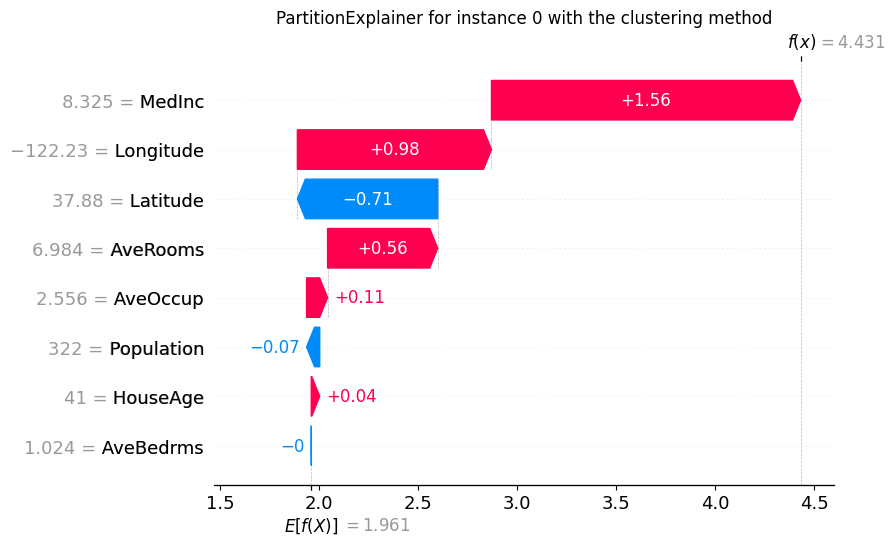

In [144]:
fig, ax = plt.subplots()
shap.plots.waterfall(winter_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()